# Plug-and-Play and denoiser training

In [1]:
#INSTAL DEEP INVERSE
%%capture
!pip install git+https://github.com/deepinv/deepinv.git

In [2]:
#IMPORT LIBRARY
import deepinv as dinv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torchvision import transforms, datasets

from deepinv.models import DnCNN

In [3]:
# SET RANDOOM SEED FROM PYTORCH: to ensure repetibility
torch.manual_seed(42)

# SET DEVICE: to use GPU on colab, first change the runtime to T4 GPU
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# Use parallel dataloader if using a GPU to fasten training.
num_workers = 5 if torch.cuda.is_available() else 0

# STEP 1: LOAD THE DATASET BLUR (DATASET FO PROBLEM)

WE NEED TO UPLOAD THE FOLDER WE HAVE IN OUR DEVICE TO COLLAB BY DRAGGING SINGLE ELEMENT, CREATE A FOLDER AND MOVE THE ELEMENTS INTO THE FOLDES

In [4]:
#1. ADD THE PATH
blurred_data_path = 'blur/deblur0.h5'

#2. LOAD TRAIN DATASET: by setting train=True
blur_train_dataset = dinv.datasets.HDF5Dataset(path=blurred_data_path, train=True)

#3. LOAD TEST DATASET: by setting train=False
blur_test_dataset = dinv.datasets.HDF5Dataset(path=blurred_data_path, train=False)


# STEP 2: DEFINE PHYSICS OF THE INITIAL PROBLEM

In [5]:
#1. DEFINE FILTER: Gaussian Blur
filter = dinv.physics.blur.gaussian_blur(sigma=(2, 0.1), angle=45.0).to(device=device)

#2. DEFINE NOISE: Gaussian Noise
noise_model = dinv.physics.GaussianNoise(sigma=0.1)

#3. DEFINE OPERATOR
blur_physics = dinv.physics.BlurFFT(filter=filter,img_size=(1, 28, 28),device=device,noise_model=noise_model)

# STEP 3.1: RECONSTRUCTION MODEL = VARIATIONAL MODEL

In [6]:
#1. DATA FIDELITY L2
data_fidelity = dinv.optim.data_fidelity.L2()

#2. TV PRIOR
prior = dinv.optim.prior.TVPrior(n_it_max=10)

#3. PARAMETERS:
params_algo = {"stepsize": 1, "lambda": 0.03}

#4. RECONSTRUCTION MODEL (TOTAL VARIATION)
modelVAR = dinv.optim.optim_builder(
    iteration="PGD", # proximal gradient descent
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=True,
    max_iter=500,
    crit_conv="cost",
    thres_conv=1e-5,
    backtracking=False,
    verbose=False,
)


# STEP 4.1: TEST THE NEW MODEL

The model with TV prior does not need any training so WE SKIP THE TRAINING STEP AND GO TO THE TEST STEP.

Test:  98%|████████████████████████████████▎| 49/50 [01:09<00:01,  1.41s/it, PSNR=16.9, PSNR no learning=-22.3, SSIM=0.523, SSIM no learning=0.000439]

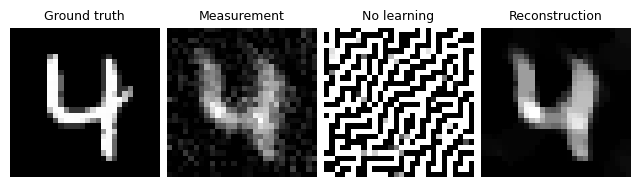

Test: 100%|█████████████████████████████████| 50/50 [01:10<00:00,  1.40s/it, PSNR=16.9, PSNR no learning=-22.3, SSIM=0.523, SSIM no learning=0.000439]

Test results:
PSNR no learning: -22.339 +- 0.415
PSNR: 16.943 +- 2.048
SSIM no learning: 0.000 +- 0.001
SSIM: 0.523 +- 0.091


{'PSNR no learning': np.float64(-22.33906982421875),
 'PSNR no learning_std': np.float64(0.41479288648582907),
 'PSNR': np.float64(16.9431591796875),
 'PSNR_std': np.float64(2.0481035387697757),
 'SSIM no learning': np.float64(0.0004387108609080315),
 'SSIM no learning_std': np.float64(0.0005747218189441801),
 'SSIM': np.float64(0.5226076507568359),
 'SSIM_std': np.float64(0.09065144461320025)}

In [8]:
batch_size = 1

#1. LOAD THE TEST DATASET
test_dataloader = DataLoader(blur_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

#2. TEST THE NEW MODEL ON THE TEST DATASET
dinv.training.test(
    model=modelVAR,
    test_dataloader=test_dataloader,
    physics=blur_physics,
    metrics = [dinv.loss.metric.PSNR(), dinv.loss.metric.SSIM()],   #PSNR is automatic
    device=device,
    verbose=True,
    plot_images = True,
)

#STEP 3.2: RECONSTRUCTED MODEL = DnCNN PnP

In [9]:
#1. DATA FIDELITY L2
data_fidelity = dinv.optim.data_fidelity.L2()

#2. DENOISER
denoiser_trained = DnCNN(
    in_channels=1,
    out_channels=1,
    pretrained="download",
    device=device,
)

#3. PRIOR
prior_PnP_trained = dinv.optim.prior.PnP(denoiser=denoiser_trained)

#4. PARAMETERS
params_algo = {"stepsize": 0.1, "g_param": 0.05 }

#5. RECONSTRUCTION MODEL
model_PnP_trained = dinv.optim.optim_builder(
    iteration="PGD", # proximal gradient descent
    prior=prior_PnP_trained,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=True,
    max_iter=500,
    crit_conv="residual",
    thres_conv=1e-5,
    backtracking=False,
    verbose=False,
)



Downloading: "https://huggingface.co/deepinv/dncnn/resolve/main/dncnn_sigma2_gray.pth?download=true" to /root/.cache/torch/hub/checkpoints/dncnn_sigma2_gray.pth
100%|██████████| 2.55M/2.55M [00:00<00:00, 5.81MB/s]


# STEP 4.2: TEST THE OLD MODEL

Test:  98%|████████████████████████████████▎| 49/50 [10:36<00:12, 12.53s/it, PSNR=18.7, PSNR no learning=-22.3, SSIM=0.819, SSIM no learning=0.000439]

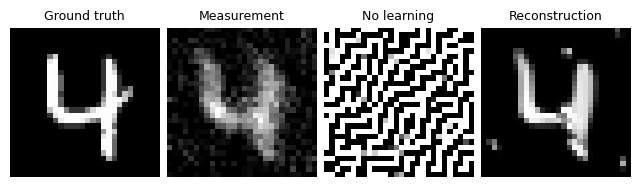

Test: 100%|█████████████████████████████████| 50/50 [10:36<00:00, 12.73s/it, PSNR=18.7, PSNR no learning=-22.3, SSIM=0.819, SSIM no learning=0.000439]

Test results:
PSNR no learning: -22.339 +- 0.415
PSNR: 18.716 +- 1.930
SSIM no learning: 0.000 +- 0.001
SSIM: 0.819 +- 0.067


{'PSNR no learning': np.float64(-22.33906982421875),
 'PSNR no learning_std': np.float64(0.41479288648582907),
 'PSNR': np.float64(18.716470947265623),
 'PSNR_std': np.float64(1.9296525672156322),
 'SSIM no learning': np.float64(0.0004387108609080315),
 'SSIM no learning_std': np.float64(0.0005747218189441801),
 'SSIM': np.float64(0.8193196868896484),
 'SSIM_std': np.float64(0.06721278006417147)}

In [10]:
batch_size = 1

#1. LOAD THE TEST DATASET
test_dataloader = DataLoader(blur_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

#2. TEST THE NEW MODEL ON THE TEST DATASET
dinv.training.test(
    model=model_PnP_trained,
    test_dataloader=test_dataloader,
    physics=blur_physics,
    metrics = [dinv.loss.metric.PSNR(), dinv.loss.metric.SSIM()],
    device=device,
    verbose=True,
    plot_images = True,
)

# STEP 5: TRAIN THE DENOISER

# STEP 5.1: LOAD DATASET NOISY (DATASET FOR DENOISER)

In [ ]:
#1. ADD THE PATH
noisy_data_path = 'noisy/denoise0.h5'

#2. LOAD TRAIN DATASET: by setting train=True
noisy_train_dataset = dinv.datasets.HDF5Dataset(path=noisy_data_path, train=True)

#3. LOAD TRAIN DATASET: by setting train=False
noisy_test_dataset = dinv.datasets.HDF5Dataset(path=noisy_data_path, train=False)


#STEP 5.2: DEFINE PHYSICS OF DENOISER

DENOISER HAS FIXED PHYSICS ALWAYS ADDITIVE GAUSSIAN, CAN JUST CHANGE PARAMETER

In [ ]:
#1. DEFINE NOISE: Gaussian Noise
sigma_PnP = 0.05
noise_model_PnP = dinv.physics.GaussianNoise(sigma=sigma_PnP)
#2. DEFINE MODEL: Denoiser
physics_PnP = dinv.physics.Denoising(device=device,noise_model=noise_model_PnP)

# STEP 5.3: SPLIT NOISY DATASET IN TEST AND TRAINING

In [ ]:
# SET DATALOADER SPLITTING TEST AND TRAINING
batch_size=10
#TRAIN DATASET
train_dataloader_PnP = DataLoader(noisy_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
#TEST DATASET
test_dataloader_PnP = DataLoader(noisy_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# STEP 5.4: TEST DENOISER BEFORE TRAINING

Test:   0%|                                                 | 0/5 [00:00<?, ?it/s, PSNR=26.8, PSNR no learning=26, SSIM=0.609, SSIM no learning=0.574]

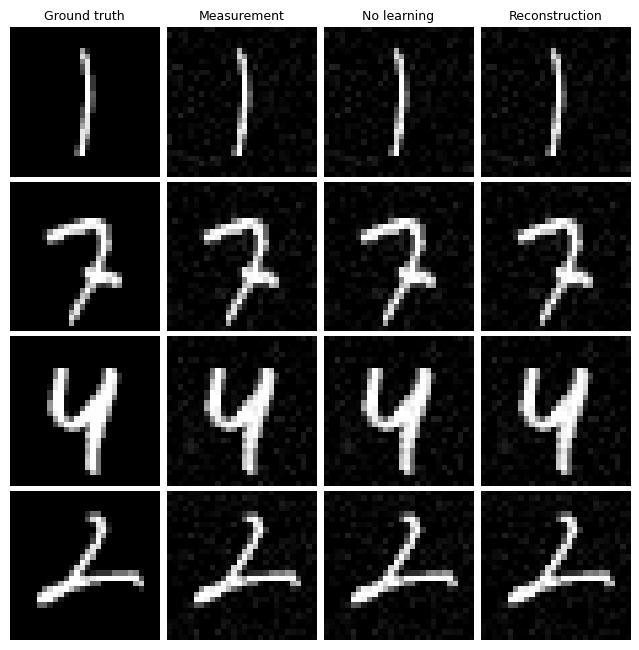

Test: 100%|█████████████████████████████████████████| 5/5 [00:00<00:00,  5.26it/s, PSNR=26.8, PSNR no learning=26, SSIM=0.609, SSIM no learning=0.574]

Test results:
PSNR no learning: 26.046 +- 0.225
PSNR: 26.822 +- 0.246
SSIM no learning: 0.574 +- 0.080
SSIM: 0.609 +- 0.079


{'PSNR no learning': np.float64(26.0455224609375),
 'PSNR no learning_std': np.float64(0.22529921615497486),
 'PSNR': np.float64(26.8222509765625),
 'PSNR_std': np.float64(0.24601712398121278),
 'SSIM no learning': np.float64(0.5738057708740234),
 'SSIM no learning_std': np.float64(0.07986335372503917),
 'SSIM': np.float64(0.6092155456542969),
 'SSIM_std': np.float64(0.07877118227973118)}

In [ ]:
#TEST DENOISER BEFORE TRAINING
dinv.training.test(
    model=denoiser_trained,
    test_dataloader=test_dataloader_PnP,
    physics=physics_PnP,
    metrics = [dinv.loss.metric.PSNR(), dinv.loss.metric.SSIM()],
    device=device,
    verbose=True,
    plot_images = True,
)

# STEP 5.5: TRAIN THE DENOISER

In [ ]:
# SET PARAMETER
learning_rate = 1e-3
epochs = 20
optimizer = torch.optim.Adam(denoiser_trained.parameters(), lr=learning_rate)
losses = [dinv.loss.SupLoss(metric=dinv.loss.metric.MSE())]

# DEFINE TRAINER
trainer_den = dinv.Trainer(
    model=denoiser_trained,
    physics=physics_PnP,
    train_dataloader=train_dataloader_PnP,
    eval_dataloader=test_dataloader_PnP,
    epochs=epochs,
    losses=losses,
    optimizer=optimizer,
    device=device,
    verbose=True,
    show_progress_bar=False,
)
# TRAIN THE DENOISER
modelDenoiser = trainer_den.train()

The model has 665921 trainable parameters
Train epoch 0: TotalLoss=0.003, PSNR=25.521
Eval epoch 0: PSNR=26.053
Best model saved at epoch 1
Train epoch 1: TotalLoss=0.002, PSNR=26.104
Eval epoch 1: PSNR=26.322
Best model saved at epoch 2
Train epoch 2: TotalLoss=0.002, PSNR=26.649
Eval epoch 2: PSNR=27.012
Best model saved at epoch 3
Train epoch 3: TotalLoss=0.001, PSNR=28.684
Eval epoch 3: PSNR=30.49
Best model saved at epoch 4
Train epoch 4: TotalLoss=0.001, PSNR=31.067
Eval epoch 4: PSNR=31.945
Best model saved at epoch 5
Train epoch 5: TotalLoss=0.001, PSNR=32.06
Eval epoch 5: PSNR=32.694
Best model saved at epoch 6
Train epoch 6: TotalLoss=0.001, PSNR=32.782
Eval epoch 6: PSNR=33.538
Best model saved at epoch 7
Train epoch 7: TotalLoss=0.0, PSNR=33.3
Eval epoch 7: PSNR=33.785
Best model saved at epoch 8
Train epoch 8: TotalLoss=0.0, PSNR=33.572
Eval epoch 8: PSNR=34.03
Best model saved at epoch 9
Train epoch 9: TotalLoss=0.0, PSNR=33.577
Eval epoch 9: PSNR=33.909
Train epoch 10: T

# STEP 5.6: TEST DENOISER AFTER TRAINING

Test:   0%|                                                   | 0/5 [00:00<?, ?it/s, PSNR=35, PSNR no learning=26, SSIM=0.966, SSIM no learning=0.574]

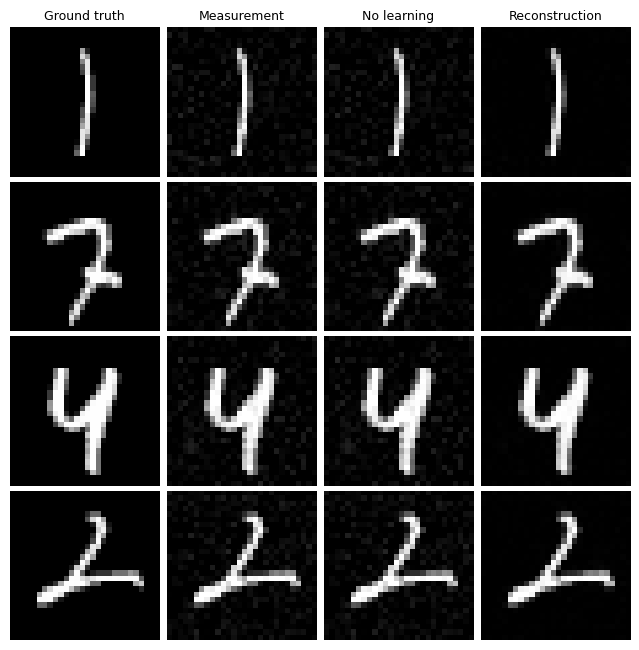

Test: 100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 14.28it/s, PSNR=35, PSNR no learning=26, SSIM=0.966, SSIM no learning=0.574]

Test results:
PSNR no learning: 26.046 +- 0.225
PSNR: 35.024 +- 1.467
SSIM no learning: 0.574 +- 0.080
SSIM: 0.966 +- 0.010


DnCNN(
  (in_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_list): ModuleList(
    (0-17): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nl_list): ModuleList(
    (0-18): 19 x ReLU()
  )
)

In [ ]:
# TEST DENOISER AFTER TRAINING
dinv.training.test(
    model=denoiser_trained,
    test_dataloader=test_dataloader_PnP,
    physics=physics_PnP,
    metrics = [dinv.loss.metric.PSNR(), dinv.loss.metric.SSIM()],
    device=device,
    verbose=True,
    plot_images = True,
)

# Training is over: now let us use the trained model
modelDenoiser.eval()

# STEP 6: RECONSTRUCTED TRAINED MODEL

Test:  98%|████████████████████████████████▎| 49/50 [00:35<00:00,  1.18it/s, PSNR=21.7, PSNR no learning=-22.3, SSIM=0.891, SSIM no learning=0.000439]

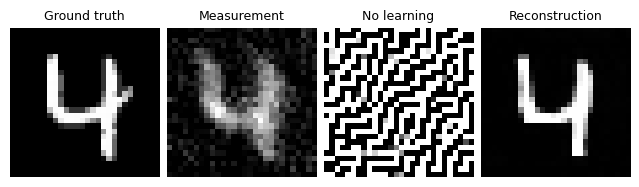

Test: 100%|█████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s, PSNR=21.7, PSNR no learning=-22.3, SSIM=0.891, SSIM no learning=0.000439]


Test results:
PSNR no learning: -22.339 +- 0.414
PSNR: 21.738 +- 2.492
SSIM no learning: 0.000 +- 0.001
SSIM: 0.891 +- 0.035


{'PSNR no learning': np.float64(-22.33908203125),
 'PSNR no learning_std': np.float64(0.41437068378846803),
 'PSNR': np.float64(21.73809814453125),
 'PSNR_std': np.float64(2.491526890528581),
 'SSIM no learning': np.float64(0.0004387101158499718),
 'SSIM no learning_std': np.float64(0.0005747215647821018),
 'SSIM': np.float64(0.8912701416015625),
 'SSIM_std': np.float64(0.03509357986489681)}

In [ ]:
#1. SET NEW PRIOR USING PnP + TRAINED DENOISER
prior_PnP_retrained = dinv.optim.prior.PnP(denoiser=modelDenoiser)

#2. SET PARAMETER
params_algo = {"stepsize": 1., "g_param": 0.05 }

#3. DEFINE RECONSTRUCTION TRAINED MODEL
model_PnP_retrained = dinv.optim.optim_builder(
    iteration="PGD",
    prior=prior_PnP_retrained,    #NEW TRAINED PRIOR
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=True,
    max_iter=500,
    crit_conv="residual",
    thres_conv=1e-5,
    backtracking=False,
    verbose=False,
)



# STEP 7: TEST THE TRAINED MODEL

In [ ]:
batch_size = 1
test_dataloader = DataLoader(blur_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# TEST TRAINED MODEL
dinv.training.test(
    model=model_PnP_retrained,        # TRAINED MODEL
    test_dataloader=test_dataloader,
    physics=blur_physics,             # PHYSICS OF MODEL
    metrics = [dinv.loss.metric.PSNR(), dinv.loss.metric.SSIM()],
    device=device,
    verbose=True,
    plot_images = True,
)